# Capstone proposal by Valentin

# CRM Predictions

# 2 - Dataset Creation

In [1]:
# Doing all imports and set up
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import time
from scipy import stats
import os
from IPython.display import Image

sns.set_style('darkgrid')

## Data loading

CSV are generated in Google Cloud Plaftorm where anonymization is performed
- Amount for order_amount and item_amount are mutliplied by a hidden factor
- All product names, product franchise, customerID, orderIDs, itemIDs are hashed using SHA256 in GCP

> The detail of SQL queries is in SQL Queries.ipynb

In [2]:
df_contact = pd.read_csv("Project_Contact.csv")
initial_contact_rows_count = df_contact.shape[0]
initial_contact_columns_count = df_contact.shape[1]

df_orders = pd.read_csv("Project_Orders.csv")
initial_orders_rows_count = df_orders.shape[0]
initial_orders_columns_count = df_orders.shape[1]

df_email = pd.read_csv("Project_Tracking.csv")
initial_tracking_rows_count = df_email.shape[0]
initial_tracking_columns_count = df_email.shape[1]

print("Contact dataframe shape: ", df_contact.shape)
print("Orders dataframe shape: ", df_orders.shape)
print("Tracking dataframe shape: ", df_email.shape)

Contact dataframe shape:  (241490, 10)
Orders dataframe shape:  (1096078, 16)
Tracking dataframe shape:  (3378031, 6)


### Contacts

We rename columns obtained in GoogleCloudPlatform using snake_case.

In [3]:
# Rename the columns using Python-appropriate names
new_column_names = {
    'CustomerId': 'customer_id',
    'contactAcquisitionDate': 'acquisition_date',
    'Language': 'language',
    'gender': 'gender',
    'RecruitmentSource': 'recruitment_source',
    'zipCode': 'zip_code',
    'birthday': 'birthdate',
    'emailDomain': 'email_domain',
    'emailDomainType': 'email_domain_type'
}
df_contact = df_contact.rename(columns=new_column_names)

# Convert acquisition_date and birthdate columns to datetime
df_contact['acquisition_date'] = pd.to_datetime(df_contact['acquisition_date']).dt.date
df_contact['birthdate'] = pd.to_datetime(df_contact['birthdate']).dt.date

# Convert all other columns to strings
df_contact = df_contact.astype({
    'customer_id': str,
    'language': str,
    'gender': str,
    'recruitment_source': str,
    'email_domain': str,
    'email_domain_type': str
})

In [4]:
df_contact.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 241490 entries, 0 to 241489
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   customer_id         241490 non-null  object
 1   acquisition_date    241490 non-null  object
 2   language            241490 non-null  object
 3   gender              241490 non-null  object
 4   recruitment_source  241490 non-null  object
 5   zip_code            111194 non-null  object
 6   city                109627 non-null  object
 7   birthdate           43595 non-null   object
 8   email_domain        241490 non-null  object
 9   email_domain_type   241490 non-null  object
dtypes: object(10)
memory usage: 18.4+ MB


There is missing values which is normal for we don't know zip_code or birthdate of every contact in database.

### Orders

The orders dataframe is a table with customer IDs
* source channels (offline or online)
* order IDs, order dates, order amounts
* item IDs, item quantities, line amounts, and various item classifications such as category, subcategory, and franchise. 

It is deduplicated at the line ID level, meaning if an customer does two orders with three items in each order, you will have 6 times the same Customer_id and three times the same orderIDs.

In [5]:
df_orders = df_orders.rename(columns={
    'CustomerId': 'customer_id',
    'sourceChannel': 'source_channel',
    'OrderId': 'order_id',
    'OrderDate': 'order_date',
    'orderAmountBeforeDiscount': 'order_amount_before_discount',
    'orderAmount': 'order_amount',
    'orderPromo': 'order_promo',
    'orderRank': 'lifetime_order_number',
    'lineID': 'item_id',
    'lineAmountBeforeDiscount': 'item_amount_before_discount',
    'lineAmount': 'item_amount',
    'linePromo': 'item_promo',
    'itemQuantity': 'item_quantity',
    'category': 'category',
    'subcategory': 'subcategory',
    'franchise': 'franchise'
})

In [6]:
# Define list names for column names
str_columns = ['customer_id', 'source_channel', 'order_id', 'item_id', 'category', 'subcategory', 'franchise']
bool_columns = ['item_promo', 'order_promo']
float_columns = ['item_amount_before_discount', 'item_amount', 'order_amount_before_discount', 'order_amount', 'item_quantity', 'lifetime_order_number']

# Change data types as necessary
for column in str_columns:
    df_orders[column] = df_orders[column].astype(str)

for column in bool_columns:
    df_orders[column] = df_orders[column].astype(bool)

for column in float_columns:
    df_orders[column] = df_orders[column].astype(float)

In [7]:
# Convert order_date to datetime format
df_orders['order_date'] = pd.to_datetime(df_orders['order_date'])

# Extract the date and time from order_date
df_orders['order_time'] = df_orders['order_date'].dt.time
df_orders['order_date'] = df_orders['order_date'].dt.date

Here we create a new column called order_weekday with a number between 0 to 6 representing the day of the week, where 0 is Monday and 6 is Sunday. We are going to use it to know whether there is a typical behavior of buying from some categories

In [8]:
df_orders['order_weekday'] = df_orders['order_date'].apply(lambda x: x.weekday())

In [9]:
df_orders.head()

,customer_id,source_channel,order_id,order_date,order_amount_before_discount,order_amount,order_promo,lifetime_order_number,item_id,item_amount_before_discount,item_amount,item_promo,item_quantity,category,subcategory,franchise,order_time,order_weekday
0,AABDtUxfsLJ76wcgdvpOQ8RCv6cV1PYwerf5NoTTrbE=,offline,t0BAcS/ZQFvkJ4+C/p8qlJ/Z2MaDiXRcpip6fyW2kHE=,2018-11-07,39.20,39.20,False,1.0,rnxbzX19LJ+o8B/aVF/YDOkJ0PbyeT1y9syLe5ECYWE=,39.20,39.20,False,1.0,Skin Care,Face Care,Franchise_IhFLxsukGLGqoga/PAIXFXYz7CpBSNd+lShx...,13:51:59,2
1,AACliddyoIuW0ieZAxmzFomASSkTcBBoRnKBuke1Z1M=,offline,Ey7Hd3H9iq60Hyz1lbMMRGArBmmgrH3G5Rn3YHZtjOM=,2015-08-06,40.64,40.64,False,3.0,38t6ytZZ8NIIJW+x10ZYvqz0bjotoznT8h3w6fK9nF8=,12.72,12.72,False,1.0,Hair,Hair,Franchise_4EWm9jhVZSw3uUYMmeGaZ1LGDExwIlhcdPws...,18:59:16,3
2,AACliddyoIuW0ieZAxmzFomASSkTcBBoRnKBuke1Z1M=,offline,Ey7Hd3H9iq60Hyz1lbMMRGArBmmgrH3G5Rn3YHZtjOM=,2015-08-06,40.64,40.64,False,3.0,EESaXPjfztIJoEMAvSEJhqxDLoRv6yzcj94EOHVZyfw=,27.92,27.92,False,1.0,Hair,Hair,Franchise_4EWm9jhVZSw3uUYMmeGaZ1LGDExwIlhcdPws...,18:59:16,3
3,AACliddyoIuW0ieZAxmzFomASSkTcBBoRnKBuke1Z1M=,offline,MMxfZryKju+9sTgvNx9GXVmJN6U98omX/yK//c1KlV8=,2015-06-20,123.84,123.84,False,1.0,z4dMP/BqAkUx2Yhdksve3nucuyv6H5fxEh+7MCb52qs=,44.00,44.00,False,1.0,Skin Care,Face Care,Franchise_wlbrAEjfxXnBF1Ow/T0gpu272409PtNqligu...,17:57:14,5
4,AACliddyoIuW0ieZAxmzFomASSkTcBBoRnKBuke1Z1M=,offline,MMxfZryKju+9sTgvNx9GXVmJN6U98omX/yK//c1KlV8=,2015-06-20,123.84,123.84,False,1.0,cjPE/SG5tF6WImf+v7mmIBMMZsNj45U/TxUGdpQJmNI=,39.92,39.92,False,1.0,Skin Care,Face Care,Franchise_Jy17YOIeZzZHmWXj/O3nAb4tt7BpFqG/iuNd...,17:57:14,5


In [10]:
df_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1096078 entries, 0 to 1096077
Data columns (total 18 columns):
 #   Column                        Non-Null Count    Dtype  
---  ------                        --------------    -----  
 0   customer_id                   1096078 non-null  object 
 1   source_channel                1096078 non-null  object 
 2   order_id                      1096078 non-null  object 
 3   order_date                    1096078 non-null  object 
 4   order_amount_before_discount  1096078 non-null  float64
 5   order_amount                  1096078 non-null  float64
 6   order_promo                   1096078 non-null  bool   
 7   lifetime_order_number         1096078 non-null  float64
 8   item_id                       1096078 non-null  object 
 9   item_amount_before_discount   1096078 non-null  float64
 10  item_amount                   1096078 non-null  float64
 11  item_promo                    1096078 non-null  bool   
 12  item_quantity               

### Email tracking

In [11]:
# Rename columns using Python-appropriate names
new_column_names = {
    'CustomerID': 'customer_id',
    'log_date': 'date',
    'Device': 'device',
    'OpenedEmail': 'opened_email',
    'ClickedEmail': 'clicked_email',
    'OptoutEmail': 'opted_out_email'
}
df_email = df_email.rename(columns=new_column_names)

# Convert date to datetime
df_email['date'] = pd.to_datetime(df_email['date'])
df_email['date'] = df_email['date'].dt.date

# Convert customer_id and device to string
df_email = df_email.astype({
    'customer_id': str,
    'device': str
})

In [12]:
df_email.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3378031 entries, 0 to 3378030
Data columns (total 6 columns):
 #   Column           Dtype 
---  ------           ----- 
 0   customer_id      object
 1   date             object
 2   device           object
 3   opened_email     int64 
 4   clicked_email    int64 
 5   opted_out_email  int64 
dtypes: int64(3), object(3)
memory usage: 154.6+ MB


## Adding Calculated KPIs

In this section, our goal is to recreate the contact database with KPIs as a snapshot based on a date. For instance if we chose Jan 1st 2022, we can
1) Exclude every contacts added to database after Jan 1st 2022
2) Reaggregate all orders / email_tracking info
3) Calculate customer RFM class at Jan 1st 2022

### Orders statistics

This function, `get_orders_stats()`, takes a DataFrame `df_orders` of customer orders and an end date `end_date_str` as arguments. The aim is to analyze customer order history up to the end date and return a summary DataFrame `df_orders_info`.

1. The function calculates a series of start dates based on the end date, ranging from 15 days ago to 36 months ago.
2. It calculates various statistics for each customer in different time frames, including the total number of orders, total order amount, and the dates of their first and last orders.
3. It then merges all of these Series into the `df_orders_info` DataFrame.

The goal is to obtain multiple feature columns for a customer at a given date. It will be interesting to see the impact of different timeframes on classification, such as varying probabilities linked to ordering 15 days, 1 month, or 3 months ago.

In [13]:
def get_orders_stats(df_orders, end_date_str):
    '''
    Takes a order dataframe as input and calculate different order statistics based on a end date
    End goal is to merge df_order_info with df_contact using customer_id   
    
    Args:
        df_orders (pandas.DataFrame): DataFrame of customer orders
        end_date_str (str): End date in string format (YYYY-MM-DD)
    
    Returns: 
        df_order_info (pandas.DataFrame): df_orders with additional columns
    '''
    df_orders_info = pd.DataFrame()    
    # Convert end_date_str to datetime.date object
    end_date = pd.to_datetime(end_date_str).date()
  
    start_date_1m = (end_date - pd.DateOffset(months=1)).date()
    start_date_3m = (end_date - pd.DateOffset(months=3)).date()
    start_date_6m = (end_date - pd.DateOffset(months=6)).date()
    start_date_12m = (end_date - pd.DateOffset(months=12)).date()
    start_date_18m = (end_date - pd.DateOffset(months=18)).date()
    start_date_24m = (end_date - pd.DateOffset(months=24)).date()
    start_date_36m = (end_date - pd.DateOffset(months=36)).date()
    
    df = df_orders.copy()

    # Filter orders up to the end date
    df = df[df['order_date'] <= end_date]
    
    # Create various dataframes on various timeranges    
    df_6m = df[(df['order_date'] >= start_date_6m)]
    df_24m = df[(df['order_date'] >= start_date_24m)]
    
    df_1m = df[(df['order_date'] >= start_date_1m)]
    df_1m_to_3m = df[(df['order_date'] >= start_date_3m) & (df['order_date'] <= start_date_1m)]
    df_3m_to_6m = df[(df['order_date'] >= start_date_6m) & (df['order_date'] <= start_date_3m)]
    df_6m_to_12m = df[(df['order_date'] >= start_date_12m) & (df['order_date'] <= start_date_6m)]
    df_12m_to_18m = df[(df['order_date'] >= start_date_18m) & (df['order_date'] <= start_date_12m)]
    df_18m_to_24m = df[(df['order_date'] >= start_date_24m) & (df['order_date'] <= start_date_18m)]
    df_24m_to_36m = df[(df['order_date'] >= start_date_36m) & (df['order_date'] <= start_date_24m)]
    df_after_36m = df[(df['order_date'] <= start_date_36m)]
    
    orders_amount_1m = df_1m.groupby('customer_id')['item_amount'].sum().reset_index(name='order_amount_1m')
    orders_amount_1m_to_3m = df_1m_to_3m.groupby('customer_id')['item_amount'].sum().reset_index(name='order_amount_1m_to_3m')
    orders_amount_3m_to_6m = df_3m_to_6m.groupby('customer_id')['item_amount'].sum().reset_index(name='order_amount_3m_to_6m')
    orders_amount_6m_to_12m = df_6m_to_12m.groupby('customer_id')['item_amount'].sum().reset_index(name='order_amount_6m_to_12m')
    orders_amount_12m_to_18m = df_12m_to_18m.groupby('customer_id')['item_amount'].sum().reset_index(name='order_amount_12m_to_18m')
    orders_amount_18m_to_24m = df_18m_to_24m.groupby('customer_id')['item_amount'].sum().reset_index(name='order_amount_18m_to_24m')
    orders_amount_24m_to_36m = df_24m_to_36m.groupby('customer_id')['item_amount'].sum().reset_index(name='order_amount_24m_to_36m')
    orders_amount_after_36m = df_after_36m.groupby('customer_id')['item_amount'].sum().reset_index(name='order_amount_after_36m')

    # Series that count orders and orders amount for RFM
    df_orders_info = df.groupby('customer_id')['order_id'].nunique().reset_index(name='total_orders')   
    orders_amount_total = df.groupby('customer_id')['item_amount'].sum().reset_index(name='total_orders_amount')
    orders_6m = df_6m.groupby('customer_id')['order_id'].nunique().reset_index(name='orders_6m')
    orders_24m = df_24m.groupby('customer_id')['order_id'].nunique().reset_index(name='orders_24m')
    orders_amount_6m = df_6m.groupby('customer_id')['item_amount'].sum().reset_index(name='order_amount_6m')
    orders_amount_24m = df_24m.groupby('customer_id')['item_amount'].sum().reset_index(name='order_amount_24m')
    
    # Series with order dates
    first_order_date = df.groupby('customer_id')['order_date'].min().reset_index(name='first_order_date')
    last_order_date = df.groupby('customer_id')['order_date'].max().reset_index(name='last_order_date')
    last_online_order_date = df[df['source_channel'] == 'online'].groupby('customer_id')['order_date'].max().reset_index(name='last_online_order_date')
    last_offline_order_date = df[df['source_channel'] == 'offline'].groupby('customer_id')['order_date'].max().reset_index(name='last_offline_order_date')

    # Merge for RFM
    df_orders_info = df_orders_info.merge(orders_6m, on='customer_id', how='left')
    df_orders_info = df_orders_info.merge(orders_24m, on='customer_id', how='left')  
    df_orders_info = df_orders_info.merge(orders_amount_6m, on='customer_id', how='left')
    df_orders_info = df_orders_info.merge(orders_amount_24m, on='customer_id', how='left')
    df_orders_info = df_orders_info.merge(orders_amount_total, on='customer_id', how='left')
    
    # Merge for creating features
    df_orders_info = df_orders_info.merge(orders_amount_1m, on='customer_id', how='left')
    df_orders_info = df_orders_info.merge(orders_amount_1m_to_3m, on='customer_id', how='left')
    df_orders_info = df_orders_info.merge(orders_amount_3m_to_6m, on='customer_id', how='left')
    df_orders_info = df_orders_info.merge(orders_amount_6m_to_12m, on='customer_id', how='left')
    df_orders_info = df_orders_info.merge(orders_amount_12m_to_18m, on='customer_id', how='left')
    df_orders_info = df_orders_info.merge(orders_amount_18m_to_24m, on='customer_id', how='left')
    df_orders_info = df_orders_info.merge(orders_amount_24m_to_36m, on='customer_id', how='left')
    df_orders_info = df_orders_info.merge(orders_amount_after_36m, on='customer_id', how='left')
    
    df_orders_info = df_orders_info.merge(first_order_date, on='customer_id', how='left')
    df_orders_info = df_orders_info.merge(last_order_date, on='customer_id', how='left')
    df_orders_info = df_orders_info.merge(last_online_order_date, on='customer_id', how='left')
    df_orders_info = df_orders_info.merge(last_offline_order_date, on='customer_id', how='left')
    
    return df_orders_info

### Time-intervals

Function `get_days_intervals()` to calculate the days between certain dates and to add new columns to a given dataframe.
1) Calculates days between the customer's first order and acquisition date
2) Days between the customer's acquisition date and the specified end_date, also called `generation_date`
> This will be used as a branching in RFM segmentation to distinguish between New Customers (newly acquired) and old reactivated Customers.
3) Days between the customer's last order date and the specified end_date
> This one will be used for `Recency` in later RFM segmentation

The `generation_date` is the date at which the snapshot of the database is taken, also named `end_date_str` in function

The function returns the updated df_contact dataframe with the added columns.

In [14]:
def get_days_intervals(df_contact, end_date_str):
    """
    Calculates various time intervals based on end-date.
    This should be run after get_order_statistics

    Args:
        df_contact (pandas.DataFrame): original dataframe with additional order statistics
        using merge on df_order_info gotten out of get_order_statistics().
        end_date_str (str): A string representing the end date of the analysis.

    Returns:
        pandas.DataFrame: update df_contact with calculated intervals
    """
    
    # Convert end_date_str to datetime.date object
    end_date = pd.to_datetime(end_date_str).date()
    
    # Extract month integer from end_date_str and add as a new column to df_contact
    df_contact['generation_month'] = pd.to_datetime(end_date_str).month
    df_contact['generation_date'] = end_date
    
    # Calculate days until first order
    df_contact['days_until_first_order'] = df_contact['first_order_date'] - df_contact['acquisition_date']
    # Recruitment: Compute the days between acquisition_date and generation_date
    df_contact['days_since_acquisition'] = df_contact['generation_date'] - df_contact['acquisition_date']

    # Recency
    df_contact['days_since_last_order'] = end_date - df_contact['last_order_date']  
    
    return df_contact

### RFM segmentation

Note that this part in repeated in project_proposal as this is a core concept in understanding projet.

__What is RFM__

From my experience working at L'Oréal, customer relationship management (CRM) programs need to identify and leverage differences across customers to be successful. This becomes difficult especially with new customers, as they have only made one purchase and lack repeated observations.

The goal would be to understand what drives differences across recently acquired customers and what characteristics may reflect underlying preferences and attitudes. For this, one of the methodology is to use RFM segmentation

**What is RFM segmentation ?** RFM analysis is a customer segmentation technique that stands for **Recency, Frequency, and Monetary**. These are indicators of customer behavior, each one reflects a different aspect of customer engagement.

- **Recency** refers to the amount of time since a customer's last purchase, and is a key factor in determining their level of engagement. Customers who have made a purchase more recently are more likely to be retained, while those who have not made a purchase in a long time may be at risk of churning. 
> Here our recency indicator is `days_since_last_order`

- **Frequency** measures how often a customer makes a purchase. Customers who purchase frequently are generally more satisfied and engaged.
> Frequency indicator is number of orders in last 2 years `orders_24m'`.

- **Monetary** reflects the amount of money that a customer has spent with the business. This metric is important because it helps to differentiate high-value customers from low-value ones.
> Monetary indicator is amount of orders in last 2 years `order_amount_24m`.

Our RFM Segmentation splits database in the following segments

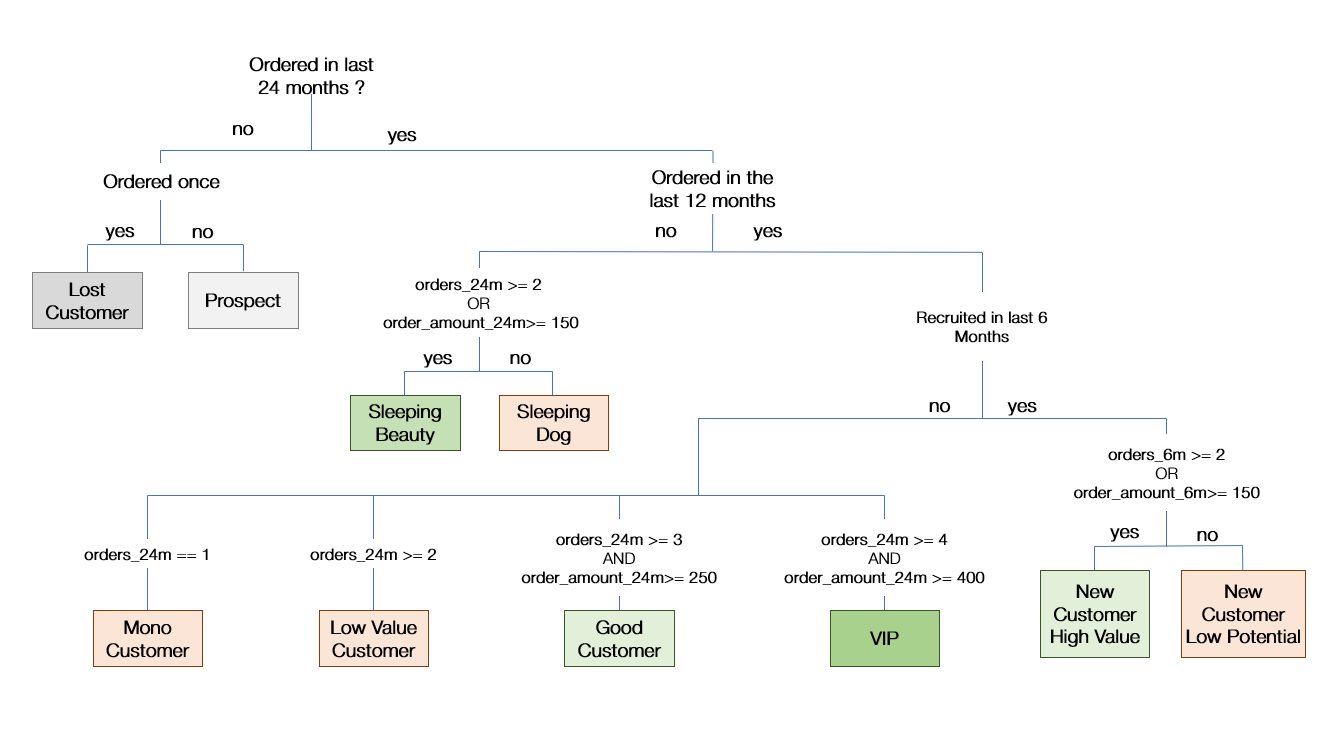

In [15]:
Image(filename='RFM.png', width=900, height=900)

The quality of RFM segmentation presented above is not its mathematical perfection, but the fact it comes from pre existing norms used by Management. In fact, one of the important factor to take into consideration when building RFM is industry recency norms for instance (how frequent should a customer buy a product, not the same answer for a car or a tomato).

To rephrase, the main advantage of RFM is readability across the organization and we will try to make predictions on RFM label, knowing that there might be better statistical methods to assign labels.

### Function get_rfm_scores()

Function `get_rfm_scores` in a pandas DataFrame df_contact, and returns the same df with a new column rfm_labels that indicates the RFM score for each customer based on their behavior.

* Function defines conditions and corresponding labels for each RFM score category based on the Recency/Frequency/Monetary defined earlier.
    * __Recency__ indicator is `days_since_last_order`
    * __Frequency__ indicator is number of orders in last 2 years `orders_24m`.
    * __Monetary__ indicator is amount of orders in last 2 years `order_amount_24m`.

In [16]:
def get_rfm_scores(df_contact):
    """
    Assign RFM scores to each customer in the input DataFrame based on their behavior.
    
    Args:
        df_contact (pd.DataFrame): df_contact has to have been run through functions
        get_order_statistics() and get_days_intervals() for this to work
    
    Returns:
        pd.DataFrame: A modified DataFrame with a new column 'rfm_labels' indicating RFM score for each customer.
    """

    df = df_contact.copy()

    # Define reusable variables to improve readability
    ordered_last_year = (df['days_since_last_order'] >= pd.Timedelta(days=365)) & (df['days_since_last_order'] < pd.Timedelta(days=730))
    ordered_this_year = (df['days_since_last_order'] >= pd.Timedelta(days=0)) & (df['days_since_last_order'] < pd.Timedelta(days=365))
    acquired_last_6M = (df['days_since_acquisition'] <= pd.Timedelta(days=180))
    
    # RFM label speicific logical condition
    
    # For New customers, only orders in past 6 months are looked at
    high_value_new_customer = acquired_last_6M & ((df['orders_6m'] >= 2) | (df['order_amount_6m'] >= 150))
    low_value_new_customer = acquired_last_6M & np.logical_not((df['orders_6m'] >= 2) | (df['order_amount_6m'] >= 150))
    
    # For the following RFM labels, past two years orders are taking into account
    sleeping_beauty = ((df['orders_24m'] >= 2) | (df['order_amount_24m'] >= 150))
    sleeping_dog = np.logical_not(((df['orders_24m'] >= 2) | (df['order_amount_24m'] >= 150)))
    vip_customer = np.logical_not(acquired_last_6M) & (df['orders_24m'] >= 4) & (df['order_amount_24m'] >= 400)
    good_customer = np.logical_not(acquired_last_6M) & ((df['order_amount_24m'] > 250) & (df['orders_24m'] >= 3))
    low_value_customer = np.logical_not(acquired_last_6M) & (df['orders_24m'] >= 2)
    mono_customer = np.logical_not(acquired_last_6M) & (df['orders_24m'] == 1)
    
    # Conditions for each RFM label
    conditions = [
        # Sleeping Beauty
        ordered_last_year & sleeping_beauty,
        # Sleeping Dog
        ordered_last_year & sleeping_dog,
        # New Customer High Value
        ordered_this_year & high_value_new_customer,
        # New Customer Low Potential
        ordered_this_year & low_value_new_customer,
        # VIP
        ordered_this_year & vip_customer,
        # Good Customers
        ordered_this_year & good_customer,
        # Low Value Customers
        ordered_this_year & low_value_customer,
        # Mono Customer
        ordered_this_year & mono_customer
    ]
    # Corresponding RFM name for each condition
    choices = ['Sleeping Beauty', 'Sleeping Dog', 'New Customer High Value', 'New Customer Low Potential', 'VIP', 'Good Customers', 'Low Value Customers', 'Mono Customer']
    
    # Apply conditions using np.select()
    df['rfm_labels'] = np.select(conditions, choices)
    
    # Special condition to distinguish between Prospect and Lost Customer
    condition_loss_customer = (df['rfm_labels'] == '0') & (df['total_orders'] > 0)
    df.loc[condition_loss_customer, 'rfm_labels'] = 'Lost Customer'
    df.loc[df['rfm_labels'] == '0', 'rfm_labels'] = 'Prospect'
    
    return df

### Promo intensity, purchase channels

In this section, we calculate KPIs that are based on order_id type. Based on a given date, we calculate preferred channels of purchase and the intensity of promo. 

Function `get_purchase_behavior()` calculates 
* __promo_rate__ by dividing number of orders with a promo by the total number of orders for each customer. 
* __purchase_channel__ either "online", "offline", and "multichannel" (purchased both offline and online)

In [17]:
def get_purchase_behavior(df_orders, end_date_str):
    """
    Extract from purchase data customer preferred channel and overall promo rate
    Dataframe returned by this function should be merged with df_contact
    
    Args:
        df_orders (pandas.DataFrame): DataFrame of customer orders
        end_date_str (str): End date in string format (YYYY-MM-DD)
    
    Returns:
        pd.DataFrame: A dataframe containing each customer's purchase channel and overall promo rate
    """
    # Convert end_date_str to datetime.date object
    end_date = pd.to_datetime(end_date_str).date()
    
    df = df_orders.copy()
    # Filter orders up to the end date
    df = df[df['order_date'] <= end_date]

    # Calculate number of unique source channels and order IDs for each customer
    grouped = df.groupby("customer_id").agg({"source_channel": pd.Series.unique, "order_id": pd.Series.nunique})

    promo_rate = df.loc[df_orders["order_promo"] == True].groupby("customer_id")["order_id"].nunique() / grouped["order_id"]
    purchase_channel = grouped.apply(lambda x: x["source_channel"] if x["source_channel"][0] == "o" else "multichannel", axis=1)
    df_purchase_channel = pd.concat([purchase_channel.rename("purchase_channel"), promo_rate.rename("promo_rate")], axis=1)
    
    return df_purchase_channel

### Item diversity, item categories

In this section, we calculate KPIs that are based on item_id and various item classifications such as category, subcategory, and franchise.

Function get_item_diversity() groups the orders by customer ID and aggregates the number of unique items purchased by each customer. It also calculates the item diversity for each customer, which is the ratio of unique items to the total number of items purchased.

The goal is to obtain additional features and investigate if there are features that serve as a good proxy for predicting a customer's RFM classification. For example, does it matter if a customer is buying only SkinCare products or not? Is a good customer more inclined to explore categories or repurchase the same products?

In [18]:
def get_item_diversity(df_orders, end_date_str):
    """
    Returns a new DataFrame containing the results of an analysis of item diversity for each customer.

    Args:
        df_orders (pandas.DataFrame): DataFrame of customer orders
        end_date_str (str): End date in string format (YYYY-MM-DD)

    Returns:
        pd.DataFrame: a new dataframe with additional information about item classifications in orders
    """

    # Convert end_date_str to datetime.date object
    end_date = pd.to_datetime(end_date_str).date()

    df = df_orders.copy()
    # Filter orders up to the end date
    df = df[df['order_date'] <= end_date]

    aggregation_functions = {
        'item_id': 'nunique'
    }

    # Group orders by customer_id and aggregate 
    df_agg = df.groupby('customer_id').agg(aggregation_functions)

    # Calculate average number of unique categories, subcategories, franchises and items overall
    items_count = df.groupby('customer_id')['item_id'].count()
    df_agg['item_diversity'] = df_agg['item_id'] / items_count

    # Create a new dataframe to store results
    df_results = pd.DataFrame()

    # Get top category, subcategory, franchise and item for each customer
    df_results['top_subcategory'] = df.groupby('customer_id')['subcategory'].apply(lambda x: x.value_counts().index[0])

    subcategories = ['Body Care', 'Hair', 'Sun Care', 'Face Cleansing', 'Deodorants', 'Shaving', 'Soaps']

    for subcategory in subcategories:
        df_results[f'bought_{subcategory.lower().replace(" ", "_")}'] = (
            df[df['subcategory'] == subcategory]
            .groupby('customer_id')['item_id']
            .count()
            .apply(lambda x: 1 if x > 0 else 0)
        )

    df_results = df_results.join(df_agg['item_diversity'])
    df_results = df_results.fillna(0)
    return df_results


### Purchase behavior

Function `get_purchase_path()` calculates metrics such as the total amount spent, the channel used, and item diversity (how varied were the items in each purchase) for each customer's first, second, and third orders. It also calculates metrics related to promotional rates, purchase shifts (CHF increase or decrease from one order to the next), and days since the last order (how many days between consecutive orders).

The function returns a DataFrame with all of these metrics for each customer.

The goal is to obtain additional features and investigate if there are features that serve as a good proxy for predicting a customer's RFM classification.

In [19]:
def get_purchase_path(df_orders, end_date_str):
    """
    Computes information about customers 1st, 2nd and 3rd purchases
    Args:
        df_orders (pandas.DataFrame): DataFrame of customer orders
        end_date_str (str): End date in string format (YYYY-MM-DD)

    Returns:
        pandas.DataFrame: DataFrame with various metrics related to each customer's first, second, and third purchases
    """
    # Convert end_date_str to datetime.date object
    end_date = pd.to_datetime(end_date_str).date()
    
    df = df_orders.copy()
    # Filter orders up to the end date
    df = df[df['order_date'] <= end_date]

    df_first_orders = df[df['lifetime_order_number'] == 1]
    df_second_orders = df[df['lifetime_order_number'] == 2]
    df_third_orders = df[df['lifetime_order_number'] == 3]
    df_fourth_orders = df[df['lifetime_order_number'] == 4]
    df_fifth_orders = df[df['lifetime_order_number'] == 5]

    # Group orders by customer_id and aggregate
    grouped_first_orders = df_first_orders.groupby('customer_id').agg(
        first_order_total_amount=('item_amount', 'sum'),
        first_order_channel=('source_channel', 'first'),
        first_order_date=('order_date', 'first'),
    )

    df_results = grouped_first_orders.reset_index()

    # Group orders by customer_id and aggregate
    grouped_second_orders = df_second_orders.groupby('customer_id').agg(
        second_order_total_amount=('item_amount', 'sum'),
        second_order_channel=('source_channel', 'first'),
        second_order_date=('order_date', 'first'),
    ).reset_index()

    # Group orders by customer_id and aggregate
    grouped_third_orders = df_third_orders.groupby('customer_id').agg(
        third_order_total_amount=('item_amount', 'sum'),
        third_order_channel=('source_channel', 'first'),
        third_order_date=('order_date', 'first'),
    ).reset_index()
    
    # Group orders by customer_id and aggregate
    grouped_fourth_orders = df_fourth_orders.groupby('customer_id').agg(
        fourth_order_total_amount=('item_amount', 'sum'),
        fourth_order_date=('order_date', 'first'),
    ).reset_index()
    
    # Group orders by customer_id and aggregate
    grouped_fifth_orders = df_fifth_orders.groupby('customer_id').agg(
        fifth_order_total_amount=('item_amount', 'sum'),
        fifth_order_date=('order_date', 'first'),
    ).reset_index()

    df_results = df_results.merge(grouped_second_orders, on='customer_id', how='left')
    df_results = df_results.merge(grouped_third_orders, on='customer_id', how='left')
    df_results = df_results.merge(grouped_fourth_orders, on='customer_id', how='left')
    df_results = df_results.merge(grouped_fifth_orders, on='customer_id', how='left')


    # Add second_purchase_amount_shift column
    df_results['second_order_amount_shift'] = df_results.apply(
        lambda row: row['second_order_total_amount'] - row['first_order_total_amount'] if 
        isinstance(row['second_order_total_amount'], float) else 
        np.nan, 
        axis=1
    )

    # Add third_purchase_amount_shift column
    df_results['third_order_amount_shift'] = df_results.apply(
        lambda row: row['third_order_total_amount'] - row['second_order_total_amount'] if 
        (isinstance(row['second_order_total_amount'], float) and isinstance(row['third_order_total_amount'], float)) else 
        np.nan, 
        axis=1
    )
    
    # Add fourth_purchase_amount_shift column
    df_results['fourth_order_amount_shift'] = df_results.apply(
        lambda row: row['fourth_order_total_amount'] - row['third_order_total_amount'] if 
        (isinstance(row['third_order_total_amount'], float) and isinstance(row['fourth_order_total_amount'], float)) else 
        np.nan, 
        axis=1
    )
    
    # Add fifth_purchase_amount_shift column
    df_results['fifth_order_amount_shift'] = df_results.apply(
        lambda row: row['fifth_order_total_amount'] - row['fourth_order_total_amount'] if 
        (isinstance(row['fourth_order_total_amount'], float) and isinstance(row['fifth_order_total_amount'], float)) else 
        np.nan, 
        axis=1
    )

    # Add third_purchase_days_since_last_order
    df_results['second_order_days_gap'] = df_results.apply(
        lambda row: (row['second_order_date'] - row['first_order_date']).days if 
        pd.notnull(row['second_order_date']) else 
        np.nan, 
        axis=1
    )

    # Add third_purchase_days_since_last_order
    df_results['third_order_days_gap'] = df_results.apply(
        lambda row: (row['third_order_date'] - row['second_order_date']).days if 
        (pd.notnull(row['second_order_date']) and pd.notnull(row['third_order_date'])) else 
        np.nan, 
        axis=1
    )

    return df_results

### Average amounts

Function `get_customer_order_stats()` selects a subset of columns to keep non-duplicated values of CustomerID and OrderID to remove duplicated line by item_id. Calculates

- Mean and standard deviation of order amounts
- Mode of order time (in 4 quartiles 0-6, 6-12, 12-18, 18-24) to know if a customer is most accustomed to ordering in the afternoon or in the evening for instance 
- Mean of order weekday. Is it a pattern to order more at the start of the week (chore like task) or during week end (maybe more discovery shopping). 
- Order promo rate, ratio of the order amount after discounts to the order amount before discounts.

In [20]:
def get_customer_order_stats(df_orders, end_date_str):
    """
    Calculates aggregated statistics for each customers based on OVERALL orders
    Such as overall mean and std for order value
    
    Args:
        df_orders (pandas.DataFrame): DataFrame of customer orders
        end_date_str (str): End date in string format (YYYY-MM-DD)
    
    Returns:
        A new DataFrame with aggregated statistics for each customer based on their orders.
    """
    # Convert end_date_str to datetime.date object
    end_date = pd.to_datetime(end_date_str).date()
    
    df = df_orders.copy()
    # Filter orders up to the end date
    df = df[df['order_date'] <= end_date]
 
    # Specify which columns we want to keep non-duplicated values of
    order_level_columns = [
        'customer_id',
        'order_id',
        'order_amount_before_discount',
        'order_amount',
        'order_time',
        'order_weekday'
    ]

    # Create a new dataframe with non-duplicated values based on specified columns
    df_order_level = df.drop_duplicates(subset=order_level_columns).copy()

    # Extract hour component of order_time column and convert it to an integer
    df_order_level['order_time'] = df_order_level['order_time'].apply(lambda x: x.hour)

    # Convert order_hour into four different values
    df_order_level['order_time'] = pd.cut(
        x=df_order_level['order_time'],
        bins=[0, 6, 12, 18, 24],
        labels=['0-6', '6-12', '12-18', '18-24'],
        include_lowest=True
    )

    df_results = df_order_level.groupby('customer_id').agg({
        'order_amount_before_discount': 'sum',
        'order_amount': ['sum','mean', 'std'],
        'order_time': lambda x: x.value_counts().index[0],
        'order_weekday': ['mean']
    })

    df_results.columns = [
        'order_amount_before_discount_sum',
        'order_amount_sum',
        'order_amount_mean',
        'order_amount_std',
        'order_time_mode',
        'order_weekday_mean']

    df_results['order_promo_rate'] = df_results['order_amount_sum'] / df_results['order_amount_before_discount_sum']
    df_results = df_results.drop(['order_amount_before_discount_sum', 'order_amount_sum'], axis=1)

    return df_results

### Email behavior

Function `get_email_stats()` determines
* Preferred device for opening and clicking emails for each customer based on the sum of emails opening/clicks.
* Overall number of email clicks and opens.

In [21]:
def get_email_stats(df_email: pd.DataFrame, end_date_str: str) -> pd.DataFrame:
    """
    Computes email statistics for each customer up to the specified end date.
    
    Args:
        df_email: A pandas DataFrame containing email data for each customer.
        end_date_str (str): End date in string format (YYYY-MM-DD)
        
    Returns:
        A new pandas DataFrame containing email statistics for each customer,
        including sum of emails clicks and opens
        and preferred device for opening and clicking emails.
    """    
    # Convert end_date_str to datetime.date object
    end_date = pd.to_datetime(end_date_str).date()
    
    df = df_email.copy()
    # Filter orders up to the end date
    df = df[df['date'] <= end_date]
    
    # Create a new dataframe to store the results
    df_results = pd.DataFrame()

    # Group by customer_id and aggregate metrics
    df_results['sum_opened_email'] = df.groupby('customer_id')['opened_email'].sum()
    df_results['sum_clicked_email'] = df.groupby('customer_id')['clicked_email'].sum()

    # Find preferred device for opening 
    grouped_opens = df.groupby(['customer_id', 'device'])['opened_email'].sum().reset_index()
    grouped_opens.sort_values('opened_email', ascending=False, inplace=True)
    grouped_opens.drop_duplicates('customer_id', keep='first', inplace=True)
    grouped_opens.drop('opened_email', axis=1, inplace=True)
    grouped_opens = grouped_opens.rename(columns={'device': 'preferred_device_open'})

    # Find preferred device for clicking 
    grouped_clicks = df.groupby(['customer_id', 'device'])['clicked_email'].sum().reset_index()
    grouped_clicks.sort_values('clicked_email', ascending=False, inplace=True)
    grouped_clicks.drop_duplicates('customer_id', keep='first', inplace=True)
    grouped_clicks.drop('clicked_email', axis=1, inplace=True)
    grouped_clicks = grouped_clicks.rename(columns={'device': 'preferred_device_click'})

    df_results = df_results.merge(grouped_opens, on='customer_id', how='left')
    df_results = df_results.merge(grouped_clicks, on='customer_id', how='left')

    df_results.loc[df_results['sum_clicked_email'] == 0, 'preferred_device_click'] = np.nan

    return df_results

## Generating backdated databases

Function called `generate_backdated_contacts` takes the various dataframe loaded from SQL queries (df_contact, df_orders, df_email) and run all functions written previously in sequence.

Based on a start date + a number of month indents, it generates a list of dates with 30 days between each of them. The goal is to generate the database at different time indents, as a snapshot of all contact activities up to that date.

For each date, the function filters df_contact to include only customers that were acquired before that date. It then merges various dataframes to get relevant statistics on customer behavior, including orders, RFM scores, purchase behavior, item diversity, purchase path, customer order statistics, and email statistics.

Finally, function stores the resulting dataframe in a dictionary with the date as the key and returns the dictionary.

In [22]:
def generate_backdated_contacts(df_contact, df_orders, df_email, start_date, num_months):
    """
    Generates backdated database snapshots based on a given start date and number of months.
    
    Args:
    - df_contact (pd.DataFrame): A dataframe containing information about contacts such as acquisition date and customer ID.
    - df_orders (pd.DataFrame): A dataframe containing information about customer orders, such as order date, order ID, and customer ID.
    - df_email (pd.DataFrame): A dataframe containing information about email activties, such as customer ID and email activity data.
    - start_date (str): A string representing the start date in the format 'YYYY-MM-DD'.
    - num_months (int): An integer representing the number of months for which to generate backdated contacts.
    
    Returns:
    - backdated_contacts (dict): A dictionary where the keys are strings representing a date
    and the values are dataframes containing snapshots of database.
    """
    
    
    backdated_contacts = {}
    start_date = pd.to_datetime(start_date).date()
    
    for i in range(0, num_months+1):
        date = start_date + timedelta(days=30*i)
        print(date)
        end_date_str = date.strftime('%Y-%m-%d')
        
        # Filter to include only contacts acquired before end date
        df_contact_date = df_contact[df_contact['acquisition_date'] < date]
        
        # Merge stats on order to calculate rfm_labels
        orders_stats_df = get_orders_stats(df_orders, end_date_str)
        df_contact_date = df_contact_date.merge(orders_stats_df, on="customer_id", how="left")
        
        df_contact_date = get_days_intervals(df_contact_date, end_date_str)
        df_contact_date = get_rfm_scores(df_contact_date)
        
        # Add additional pieces of information
        purchase_behavior_df = get_purchase_behavior(df_orders, end_date_str)
        df_contact_date = df_contact_date.merge(purchase_behavior_df, on="customer_id", how="left")

        item_diversity_df = get_item_diversity(df_orders, end_date_str)
        df_contact_date = df_contact_date.merge(item_diversity_df, on="customer_id", how="left")
        
        purchase_path_df = get_purchase_path(df_orders, end_date_str)
        df_contact_date = df_contact_date.merge(purchase_path_df, on="customer_id", how="left")
        
        customer_order_stats_df = get_customer_order_stats(df_orders, end_date_str)
        df_contact_date = df_contact_date.merge(customer_order_stats_df, on="customer_id", how="left")
        
        email_stats_df = get_email_stats(df_email, end_date_str)
        df_contact_date = df_contact_date.merge(email_stats_df, on="customer_id", how="left")
        
        # Store resulting dataframe in dictionary with end date as key
        backdated_contacts[end_date_str] = df_contact_date
        
    return backdated_contacts

In [23]:
start_time = time.time()
#was 26
backdated_contacts = generate_backdated_contacts(df_contact, df_orders, df_email, "2020-06-25", 33)
end_time = time.time()

run_time = end_time - start_time

print(f"Runtime: {run_time:.2f} seconds")

2020-06-25
2020-07-25
2020-08-24
2020-09-23
2020-10-23
2020-11-22
2020-12-22
2021-01-21
2021-02-20
2021-03-22
2021-04-21
2021-05-21
2021-06-20
2021-07-20
2021-08-19
2021-09-18
2021-10-18
2021-11-17
2021-12-17
2022-01-16
2022-02-15
2022-03-17
2022-04-16
2022-05-16
2022-06-15
2022-07-15
2022-08-14
2022-09-13
2022-10-13
2022-11-12
2022-12-12
2023-01-11
2023-02-10
2023-03-12
Runtime: 2929.88 seconds


### Adding target labels

Function `add_target_label()` takes our dictionnary of database snapshots and adds target labels that are 3 months, 6 months, 9 months or 12 months afterwards

example if database is generated with key datetime.date(2020, 6, 15)
- target label 3 months after is rfm_labels at 13.09.2020
- target label 6 months after is rfm_labels at 12.12.2020
- target label 9 months after is rfm_labels at 12.03.2021
- target label 1 year after is rfm_labels at 10.06.2021

At this stage we generate multiple potential target label to discuss value of treating this problem as a multilabel multiclass classification. Intuitively, it seems there is value in estimating probable rfm_label 3 months and rfm_label 12 months after as there is a relationships between both, or else said it could help to first estimate customer class in 3 months before esimating customer class in 12 months, similarly to a proof by induction.

In [24]:
def add_target_label(backdated_contacts):
    '''
    Args:
    - backdated_contacts (dict): A dictionary where the keys are strings representing a date
    and the values are dataframes containing snapshots of database.
    
    Returns:
    dict: updated backdated_contacts dictionary with target labels and prediction dates added for customers based on their RFM scores.  
    '''
    # List to indents to loop over, matching months 
    # [3, 6, 9] is to add target_label_3M, target_label_6M, target_label_9M
    indents = [3, 6, 9, 12]
    
    for indent in indents:
        # We stop at len(backdated_contacts)-indent
        # for instance for indent equal 3 months, this matches the latest three snapshots
        # they don't have equivalent 3 months after for target_label_3M
        for current_index in range(0, len(backdated_contacts)-indent):
            # Get current and prediction dates based on ident
            # and matching dataframes in dict backdated_contacts
            current_date = list(backdated_contacts.keys())[current_index]
            prediction_date = list(backdated_contacts.keys())[current_index + indent]
            current_df = backdated_contacts[current_date]
            prediction_df = backdated_contacts[prediction_date]
            
            # Get RFM labels for prediction date and merge them into the current data frame
            rfm_labels_prediction = prediction_df[['customer_id', 'rfm_labels']]
            rfm_labels_prediction.columns = ['customer_id', f'target_label_{indent}M']
            current_df = current_df.merge(rfm_labels_prediction, on='customer_id', how='left')
            
            # Add prediction date column to current_df
            current_df[f'prediction_date_{indent}M'] = prediction_date
            
            # Replace dataframe in dictionnary with dataframe with added predictions
            backdated_contacts[current_date] = current_df
    
    # Save each data frame to a CSV file in the "by_date_files" folder
    # This was mainly used in debugging
    folder_name = "by_date_files"
    for current_date, current_df in backdated_contacts.items():
        file_path = os.path.join(folder_name, f"df_contact_{current_date}.csv")
        current_df.to_csv(file_path, index=False)
        
    return backdated_contacts

In [25]:
backdated_contacts = add_target_label(backdated_contacts)

### Stacking database snapshots

Now, we stack dataframes on top of each other. The goal ultimately is to be able to predict RFM labels, so by stacking multiple databases snapshots, we multiply training data and add a column `generation_month`.
> `generation_month` might be a valuable feature to predict future rfm_labels. In fact, in cosmetics seasonality is quite strong and october/november/december are best months in terms of sales. This means that predicting rfm_labels in september for next december will not be the same as predicting in january for april.

In [26]:
# Create a list of dataframes from backdated_contacts dictionary
dfs_to_concat = list(backdated_contacts.values())[:-2]

# Concatenate dataframes
stacked_df = pd.concat(dfs_to_concat)
stacked_df.shape

(6271974, 81)

We remove contacts that are still prospects as rfm_label in the future, meaning they have not purchased, otherwise they will be over represented.

In [27]:
# Define the conditions for filtering
prospect_label = 'Prospect'
condition = ((stacked_df['target_label_3M'] == prospect_label) & 
             (stacked_df['target_label_6M'] == prospect_label) &
             (stacked_df['target_label_9M'] == prospect_label) &
             (stacked_df['target_label_12M'] == prospect_label) |
             (stacked_df['target_label_3M'].isna()) |
             (stacked_df['target_label_6M'].isna()) |
             (stacked_df['target_label_9M'].isna()) |
             (stacked_df['target_label_12M'].isna()))

# Filter out rows where all target labels are prospects
stacked_df = stacked_df[~condition]

We want to add some granularity and remove Lost Customer that have have not ordered for three years

In [28]:
# Define the conditions for filtering
days_threshold = 1095
condition = ((stacked_df['rfm_labels'] == 'Lost Customer') & 
            (stacked_df['days_since_last_order'] >= pd.Timedelta(days=days_threshold)))
# filter out rows where the number of days is 180 and rfm_labels and target_label are both 0
stacked_df = stacked_df[~condition]

In [29]:
stacked_df.head()

,customer_id,acquisition_date,language,gender,recruitment_source,zip_code,city,birthdate,email_domain,email_domain_type,...,preferred_device_open,preferred_device_click,target_label_3M,prediction_date_3M,target_label_6M,prediction_date_6M,target_label_9M,prediction_date_9M,target_label_12M,prediction_date_12M
0,AABDtUxfsLJ76wcgdvpOQ8RCv6cV1PYwerf5NoTTrbE=,2018-10-16,de,M,Offline,NaN,NaN,1986-08-20,gmail.com,international_domain,...,proxy,proxy,Sleeping Dog,2020-09-23,Lost Customer,2020-12-22,Lost Customer,2021-03-22,Lost Customer,2021-06-20
1,AACliddyoIuW0ieZAxmzFomASSkTcBBoRnKBuke1Z1M=,2015-06-18,de,F,Offline,3074,MURI B.BERN,1900-06-01,hotmail.com,international_domain,...,iPhone,NaN,Sleeping Dog,2020-09-23,Sleeping Dog,2020-12-22,Sleeping Dog,2021-03-22,Lost Customer,2021-06-20
2,AADM2NJSd0tsnoXQISuTvPRBHv+fy66lw15Vwi4mtG8=,2017-01-28,de,F,Offline,8052,ZÜRICH,NaT,other,international_domain,...,NaN,NaN,Lost Customer,2020-09-23,Lost Customer,2020-12-22,Lost Customer,2021-03-22,Lost Customer,2021-06-20
5,AAJyqntK3NXNz2jQuK+Ayjk4aS9/YxL04KN2U2OMP7A=,2015-03-25,de,F,Offline,5024,KÜTTIGEN,NaT,other,international_domain,...,NaN,NaN,Sleeping Beauty,2020-09-23,Lost Customer,2020-12-22,Lost Customer,2021-03-22,Lost Customer,2021-06-20
10,AAOY5gVQUFcr6ffBDw0XiXvKyGpFA1IapXP6s7WJr/E=,2019-04-23,fr,M,Offline,NaN,NaN,1995-03-26,outlook.com,international_domain,...,Android,NaN,Sleeping Dog,2020-09-23,Sleeping Dog,2020-12-22,Low Value Customers,2021-03-22,Low Value Customers,2021-06-20


In [30]:
stacked_df['target_label_12M'].unique()

array(['Lost Customer', 'Low Value Customers', 'Sleeping Dog',
       'Good Customers', 'Sleeping Beauty', 'Mono Customer', 'VIP'],
      dtype=object)

In [31]:
stacked_df.to_csv("stacked_df.csv")

In [32]:
stacked_df.shape

(908423, 81)

### Keeping only VIP, Good Customers, Low Value Customers

As explain in project proposal, we keep here only three rfm_labels

In [33]:
# List of RFM labels to keep
rfm_labels_to_keep = ['Good Customers', 'VIP', 'Low Value Customers']

# Filtering df_subset to keep
stacked_df = stacked_df[stacked_df['rfm_labels'].isin(rfm_labels_to_keep)]

We remove 'Mono Customer' as potential target label, as seen in proposal, it creates too much of a class imbalance

In [34]:
stacked_df = stacked_df[stacked_df['target_label_12M'] != 'Mono Customer']

### Getting a random sample

We now get a random sample and respect equal proportions in target label so we erase some of the class imbalance issue

In [35]:
# Records to keep per label
expected_per_rfm = 26000

# Group by label and get a random sample for each
df_sampled = stacked_df.groupby('target_label_12M').apply(lambda x: x.sample(expected_per_rfm))

# Reset index of sampled DataFrame
df_sampled.reset_index(drop=True, inplace=True)

In [36]:
df_sampled.shape

(130000, 81)

In [37]:
df_sampled.head()

,customer_id,acquisition_date,language,gender,recruitment_source,zip_code,city,birthdate,email_domain,email_domain_type,...,preferred_device_open,preferred_device_click,target_label_3M,prediction_date_3M,target_label_6M,prediction_date_6M,target_label_9M,prediction_date_9M,target_label_12M,prediction_date_12M
0,fu9hy8lBGxq74A8iztOfcbgnxsXVZxdSON7FbgrzQgI=,2020-03-28,de,U,Website,NaN,NaN,1989-02-23,other,frdeit_domain,...,iPhone,iPhone,Good Customers,2021-03-22,Good Customers,2021-06-20,Good Customers,2021-09-18,Good Customers,2021-12-17
1,LEHsUCi+UtilJfKBba2aUYdjY146zQzWd6gSJ1a6E+A=,2013-12-11,de,U,Offline,8193,Eglisau,1990-11-28,hotmail.com,international_domain,...,NaN,NaN,Good Customers,2022-02-15,Good Customers,2022-05-16,Good Customers,2022-08-14,Good Customers,2022-11-12
2,l7H7/LVUrl6+4YYZJXJVeQvT3o8j23ZEnEOFnRoZobM=,2014-09-19,de,F,Offline,8004,ZÜRICH,NaT,gmail.com,international_domain,...,iPhone,iPhone,VIP,2021-04-21,Good Customers,2021-07-20,Good Customers,2021-10-18,Good Customers,2022-01-16
3,5afp06lN4MrfGcQFAKANepwewLD1HdPF9y9kdJqU7Aw=,2019-06-11,fr,F,Website,1991,ARVILLARD,NaT,gmail.com,international_domain,...,NaN,NaN,VIP,2021-09-18,VIP,2021-12-17,Good Customers,2022-03-17,Good Customers,2022-06-15
4,D69xLSHJxsygvaL41SS0fTrMQZzsgyPWLLglMg2HG3o=,2017-06-03,de,M,Offline,8003,ZÜRICH,1900-04-07,gmx.net,international_domain,...,PC,NaN,VIP,2021-07-20,Good Customers,2021-10-18,Good Customers,2022-01-16,Good Customers,2022-04-16


In [38]:
df_sampled['target_label_12M'].value_counts(normalize=True)

Good Customers         0.2
Low Value Customers    0.2
Sleeping Beauty        0.2
Sleeping Dog           0.2
VIP                    0.2
Name: target_label_12M, dtype: float64

In [39]:
df_sampled['rfm_labels'].value_counts(normalize=True)

Low Value Customers    0.531908
VIP                    0.252562
Good Customers         0.215531
Name: rfm_labels, dtype: float64

In [40]:
df_sampled['generation_month'].value_counts(normalize=True)

10    0.093154
7     0.092831
6     0.092423
9     0.091777
8     0.091585
11    0.091362
12    0.089638
1     0.088777
2     0.088631
3     0.087685
5     0.046292
4     0.045846
Name: generation_month, dtype: float64

### Saving as Pickle

We remove redundant columns and add a few date columns. We then save our sample as pickle

In [41]:
df_sampled.drop('first_order_date_y', axis=1, inplace=True)
df_sampled.rename(columns={'first_order_date_x': 'first_order_date'}, inplace=True)

In [42]:
df_sampled['days_since_first_order'] = df_sampled.apply(
    lambda row: (row['generation_date'] - row['first_order_date']).days if 
    pd.notnull(row['first_order_date']) else 
    np.nan, 
    axis=1
)

df_sampled['days_since_second_order'] = df_sampled.apply(
    lambda row: (row['generation_date'] - row['second_order_date']).days if 
    pd.notnull(row['second_order_date']) else 
    np.nan, 
    axis=1
)

df_sampled['days_since_third_order'] = df_sampled.apply(
    lambda row: (row['generation_date'] - row['third_order_date']).days if 
    pd.notnull(row['third_order_date']) else 
    np.nan, 
    axis=1
)

df_sampled['days_since_last_online_order'] = df_sampled.apply(
    lambda row: (row['generation_date'] - row['last_online_order_date']).days if 
    pd.notnull(row['last_online_order_date']) else 
    np.nan, 
    axis=1
)

df_sampled['days_since_last_offline_order'] = df_sampled.apply(
    lambda row: (row['generation_date'] - row['last_offline_order_date']).days if 
    pd.notnull(row['last_offline_order_date']) else 
    np.nan, 
    axis=1
)

In [43]:
df_sampled.to_pickle("./dataset.pkl")
df_sampled.to_csv("df_sampled.csv")

In [44]:
df_sampled['generation_date'].sort_values().unique()

array([datetime.date(2020, 6, 25), datetime.date(2020, 7, 25),
       datetime.date(2020, 8, 24), datetime.date(2020, 9, 23),
       datetime.date(2020, 10, 23), datetime.date(2020, 11, 22),
       datetime.date(2020, 12, 22), datetime.date(2021, 1, 21),
       datetime.date(2021, 2, 20), datetime.date(2021, 3, 22),
       datetime.date(2021, 4, 21), datetime.date(2021, 5, 21),
       datetime.date(2021, 6, 20), datetime.date(2021, 7, 20),
       datetime.date(2021, 8, 19), datetime.date(2021, 9, 18),
       datetime.date(2021, 10, 18), datetime.date(2021, 11, 17),
       datetime.date(2021, 12, 17), datetime.date(2022, 1, 16),
       datetime.date(2022, 2, 15), datetime.date(2022, 3, 17)],
      dtype=object)

In [45]:
df_sampled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130000 entries, 0 to 129999
Data columns (total 85 columns):
 #   Column                         Non-Null Count   Dtype          
---  ------                         --------------   -----          
 0   customer_id                    130000 non-null  object         
 1   acquisition_date               130000 non-null  object         
 2   language                       130000 non-null  object         
 3   gender                         130000 non-null  object         
 4   recruitment_source             130000 non-null  object         
 5   zip_code                       115269 non-null  object         
 6   city                           114276 non-null  object         
 7   birthdate                      88347 non-null   object         
 8   email_domain                   130000 non-null  object         
 9   email_domain_type              130000 non-null  object         
 10  total_orders                   130000 non-null  float64 